In [65]:
from pathlib import Path
from dataclasses import dataclass
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [66]:
@dataclass
class Config:
    REPO_ROOT: Path = Path("../../")
    data_dir: Path = REPO_ROOT / "data"


config = Config()

sys.path.append(str(config.REPO_ROOT))

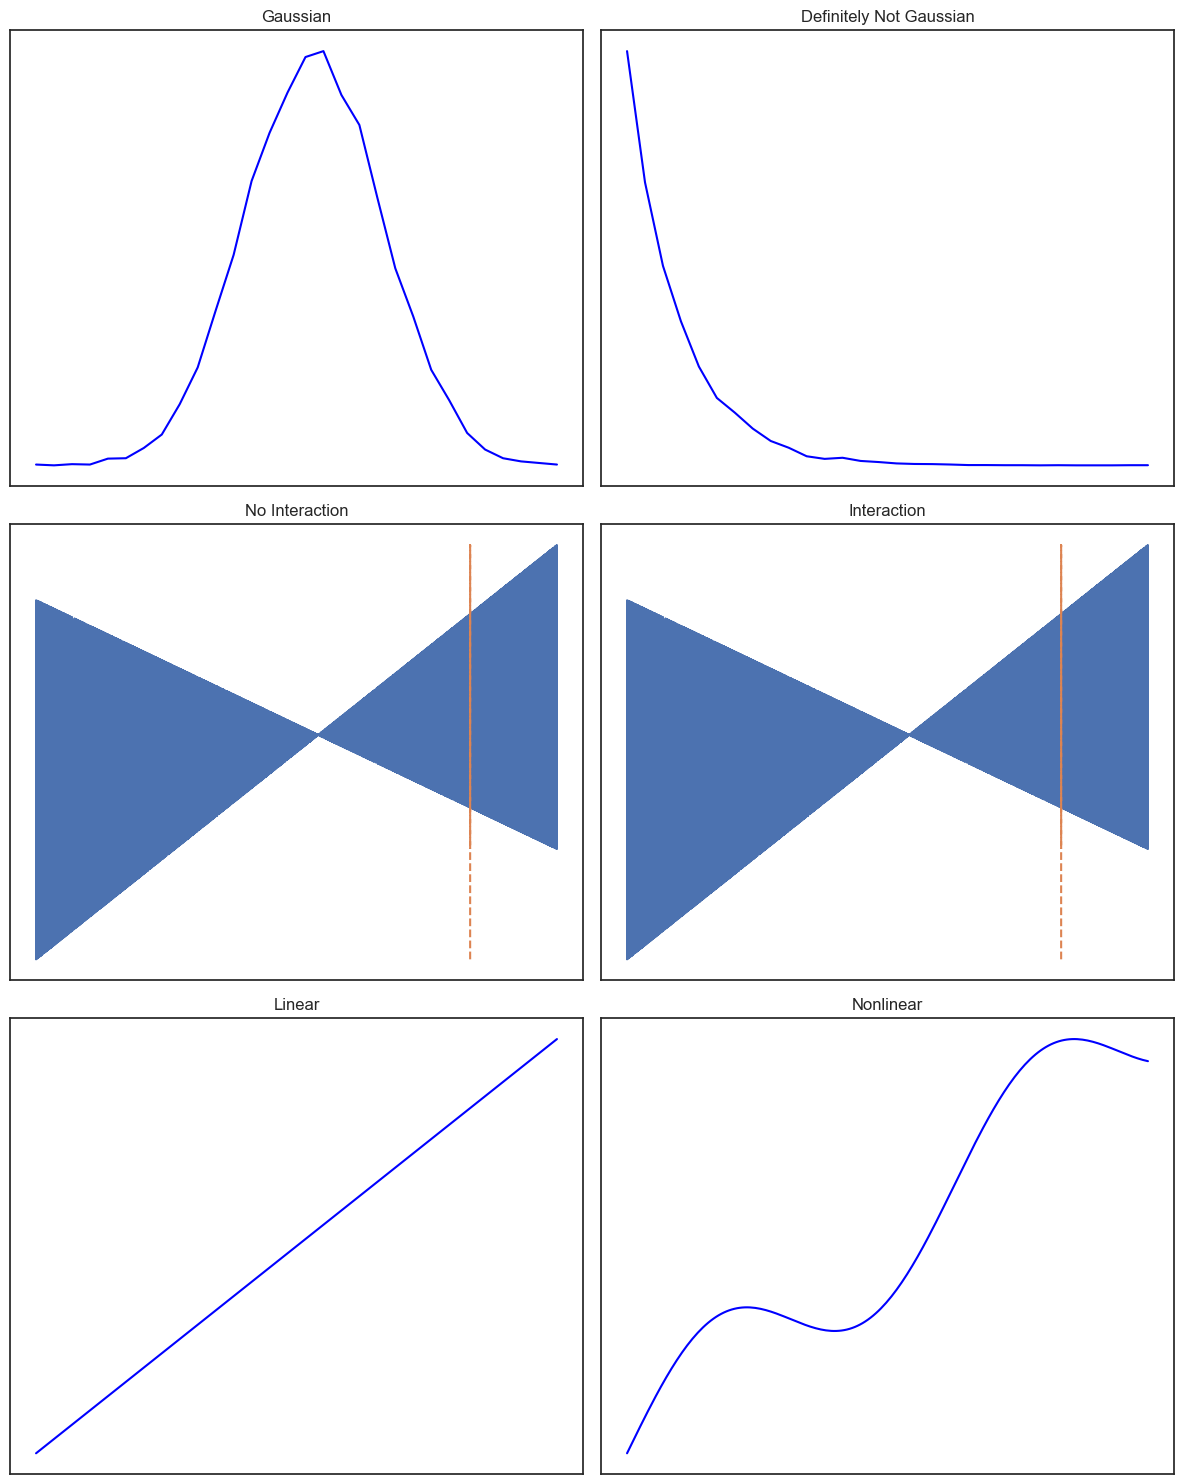

In [64]:
# 1. GLM: Gaussian vs Non-Gaussian distribution
n = 10000
df_glm = pd.DataFrame(
    {
        "x": np.concatenate(
            [np.random.normal(size=n), np.random.exponential(scale=2, size=n)]
        ),
        "dist": ["Gaussian"] * n + ["Definitely Not Gaussian"] * n,
    }
)

# 2. Interaction: with and without interaction
x1 = np.linspace(-3, 3, n)
x2 = np.random.choice([1, 2], size=n, replace=True)
y_interaction = 3 + 5 * x1 + (2 - 8 * x1) * (x2 == 2)
y_no_interaction = 3 + 5 * x1 + 0.5 * (-8 * x1) + 2 * (x2 == 2)
df_interaction = pd.DataFrame(
    {
        "x1": np.tile(x1, 2),
        "x2": np.repeat(x2, 2),
        "y": np.concatenate([y_no_interaction, y_interaction]),
        "interaction": ["No Interaction"] * n + ["Interaction"] * n,
    }
)

# 3. GAM: Linear vs Nonlinear
x = np.linspace(0, 10, 200)
y_linear = 5 + 2 * x
y_nonlinear = 3 + 2 * x + 3 * np.sin(x)
df_gam = pd.DataFrame(
    {
        "x": np.tile(x, 2),
        "y": np.concatenate([y_linear, y_nonlinear]),
        "type": ["Linear"] * len(x) + ["Nonlinear"] * len(x),
    }
)

fig, axes = plt.subplots(3, 2, figsize=(12, 15))  # 3行×2列

# 1. GLM: Gaussian vs Non-Gaussian distribution
for dist, ax in zip(["Gaussian", "Definitely Not Gaussian"], axes[0]):
    df_subset = df_glm[df_glm["dist"] == dist]
    density, bins = np.histogram(df_subset["x"], bins=30, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    ax.plot(bin_centers, density, label=dist, color="blue")
    ax.set_title(dist)
    ax.grid(False)

# 2. Interaction: with and without interaction
for interaction, ax in zip(["No Interaction", "Interaction"], axes[1]):
    df_subset = df_interaction[df_interaction["interaction"] == interaction]
    for x2_val, linestyle in zip([1, 2], ["solid", "dashed"]):
        subset = df_subset[df_subset["x2"] == x2_val]
    # ax.plot(subset["x1"], subset["y"], label=f"x2 = {x2_val}", linestyle="solid")
    # ax.plot(subset["x2"], subset["y"], label=f"x2 = {x2_val}", linestyle="solid")
    ax.set_title(interaction)
    ax.grid(False)

# 3. GAM: Linear vs Nonlinear
for gtype, ax in zip(["Linear", "Nonlinear"], axes[2]):
    df_subset = df_gam[df_gam["type"] == gtype]
    ax.plot(df_subset["x"], df_subset["y"], label=gtype, color="blue")
    ax.set_title(gtype)
    ax.grid(False)

# Remove axes' labels and ticks
for ax in axes.flatten():
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


In [63]:
df_subset

,x,y,type
200,0.000000,3.000000,Nonlinear
201,0.050251,3.251193,Nonlinear
202,0.100503,3.502005,Nonlinear
203,0.150754,3.752058,Nonlinear
204,0.201005,4.000973,Nonlinear
...,...,...,...
395,9.798995,21.501358,Nonlinear
396,9.849246,21.462984,Nonlinear
397,9.899497,21.427728,Nonlinear
398,9.949749,21.395934,Nonlinear


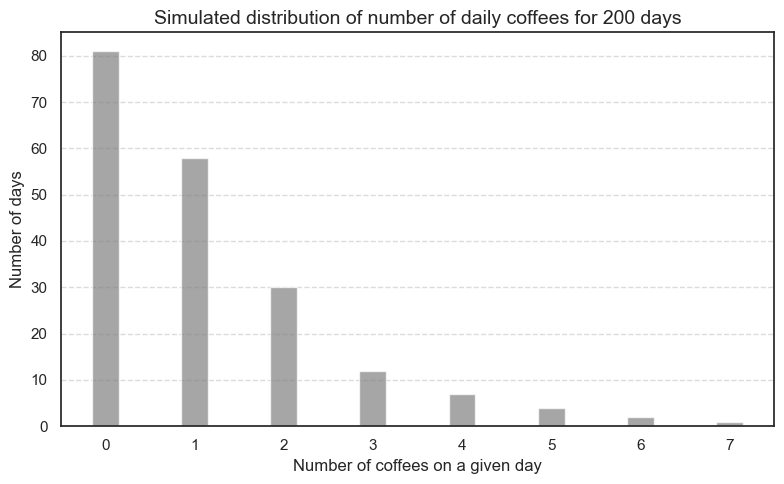

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- シミュレーションデータの作成 ----
np.random.seed(99)  # 再現性のためのシード値

n = 200
stress = np.random.uniform(1, 10, size=n)  # ストレスレベル (1~10の一様分布)
sleep = np.random.uniform(1, 10, size=n)  # 睡眠の質 (1~10の一様分布)
work = np.random.choice(["YES", "NO"], size=n, replace=True)  # 仕事あり/なし (50/50)

# λ (ポアソン分布の平均と分散)
lambda_vals = np.exp(1 * stress / 10 - 2 * (sleep - 5) / 10 - 1 * (work == "NO"))

# y: 1日のコーヒー消費回数 (ポアソン分布に基づく)
y = np.random.poisson(lam=lambda_vals, size=n)

# データフレームの作成
df = pd.DataFrame({"stress": stress, "sleep": sleep, "work": work, "y": y})

# ---- yの分布を集計 ----
tab = df["y"].value_counts().reset_index()
tab.columns = ["Number of Coffees", "Frequency"]
tab = tab.sort_values("Number of Coffees")  # 整列

# ---- プロット ----
fig, ax = plt.subplots(figsize=(8, 5))  # Fig/Axes型でプロット

# 棒グラフ
ax.bar(tab["Number of Coffees"], tab["Frequency"], color="gray", width=0.3, alpha=0.7)

# 軸ラベルとタイトル
ax.set_xlabel("Number of coffees on a given day", fontsize=12)
ax.set_ylabel("Number of days", fontsize=12)
ax.set_title(
    "Simulated distribution of number of daily coffees for 200 days", fontsize=14
)

# x軸の目盛り
ax.set_xticks(tab["Number of Coffees"])
ax.set_xlim([-0.5, 7.5])
ax.grid(axis="y", linestyle="--", alpha=0.7)

# レイアウト調整と表示
plt.tight_layout()
plt.show()


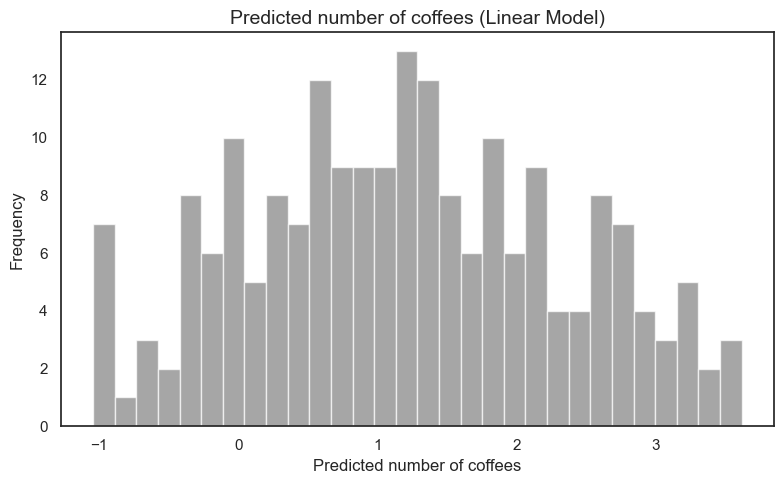

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# ---- データ生成 ----
np.random.seed(42)

n = 200
stress = np.random.uniform(1, 10, size=n)  # ストレスレベル
sleep = np.random.uniform(1, 10, size=n)  # 睡眠の質
work = np.random.choice([1, 0], size=n)  # 仕事あり(1)/なし(0)
lambda_vals = np.exp(1 * stress / 10 - 2 * (sleep - 5) / 10 - work)

# y: ポアソン分布によるコーヒー消費数
y = np.random.poisson(lam=lambda_vals, size=n)

# データフレームの作成
df = pd.DataFrame({"stress": stress, "sleep": sleep, "work": work, "y": y})

# ---- 線形モデル（Gaussian GLM） ----
X = df[["stress", "sleep", "work"]]
y = df["y"]

# 線形回帰モデル
model_gauss = LinearRegression()
model_gauss.fit(X, y)

# 予測値の取得
pred_gauss = model_gauss.predict(X)

# ---- プロット: 線形モデルの予測値 ----
fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(pred_gauss, bins=30, color="gray", edgecolor=None, alpha=0.7)
ax.set_xlabel("Predicted number of coffees", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_title("Predicted number of coffees (Linear Model)", fontsize=14)
plt.tight_layout()
plt.show()


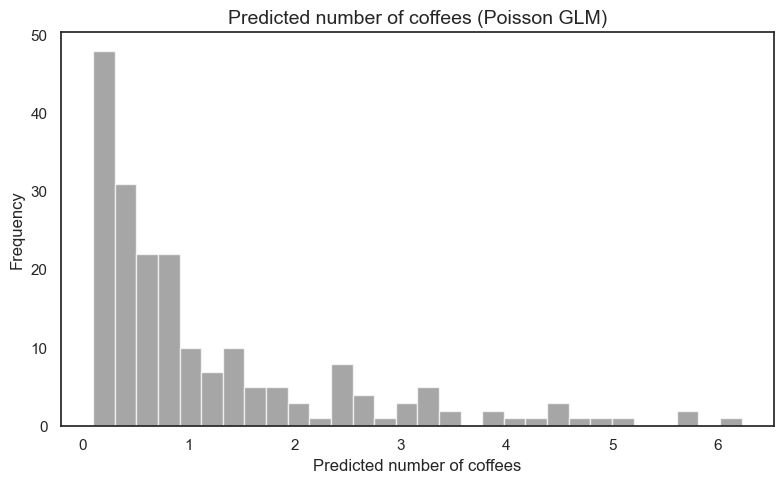

In [43]:
import statsmodels.api as sm

# ---- ポアソンGLM ----
X = df[["stress", "sleep", "work"]]
X = sm.add_constant(X)  # 切片の追加
y = df["y"]

# ポアソンGLMモデル（logリンク関数を適切に指定）
model_pois = sm.GLM(y, X, family=sm.families.Poisson(link=sm.families.links.Log()))
results_pois = model_pois.fit()

# 予測値の取得
pred_pois = results_pois.predict(X)

# ---- プロット: ポアソンGLMの予測値 ----
fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(pred_pois, bins=30, color="gray", edgecolor=None, alpha=0.7)
ax.set_xlabel("Predicted number of coffees", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_title("Predicted number of coffees (Poisson GLM)", fontsize=14)
plt.tight_layout()
plt.show()


In [60]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

# ポアソンGLMのモデルを構築（前提としてdfデータフレームがあるとします）
X = df[["stress", "sleep", "work"]]
X = sm.add_constant(X)  # 切片を追加
y = df["y"]

# ポアソンGLMのモデル（logリンク関数）
model_pois = sm.GLM(y, X, family=sm.families.Poisson(link=sm.families.links.Log()))
results_pois = model_pois.fit()

# 重み（推定値）とその標準誤差を抽出
coefficients = results_pois.summary2().tables[1]
coefficients = coefficients[
    [
        "Coef.",
        "[0.025",
        "0.975]",
    ]
]
coefficients.columns = ["weight", "[2.5%", "97.5%]"]

# 指数を取ったものを追加（exp(beta)）
coefficients["exp(weight)"] = np.exp(coefficients["weight"])

coefficients = coefficients[["weight", "exp(weight)", "[2.5%", "97.5%]"]]
display(coefficients)

,weight,exp(weight),[2.5%,97.5%]
const,1.207791,3.346085,0.804885,1.610697
stress,0.100908,1.106175,0.052461,0.149356
sleep,-0.238181,0.788060,-0.292799,-0.183562
work,-1.487470,0.225944,-1.818703,-1.156237


In [75]:
from python.src.preprocess import (
    preprocess_bike_data,
)

df_bike = pd.read_csv(config.data_dir / "bike+sharing+dataset" / "day.csv")
df_bike_processed = preprocess_bike_data(df_bike=df_bike)
assert df_bike.shape[0] == df_bike_processed.shape[0]

In [76]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols

# df_bike_processed が定義されていると仮定します。
# サンプルデータを作成 (実際のデータに合わせて変更してください)
np.random.seed(0)
n_samples = 100

bike_features_of_interest = [
    "season",
    "holiday",
    "workingday",
    "weathersit",
    "temp",
    "hum",
    "windspeed",
    "days_since_2011",
]

X = df_bike_processed[bike_features_of_interest]
y = df_bike_processed["cnt"]
dat = pd.concat([X, y], axis=1)


# 交互作用項を明示的に追加
all_columns = " + ".join(bike_features_of_interest)
model_formula = f"cnt ~ {all_columns} + temp:workingday"  # workingdayとの交互作用を追加


# patsyを使ってformulaを解釈しやすいように変更
model_formula = f"cnt ~ C(season) + C(holiday) + C(workingday) + C(weathersit) + temp + hum + windspeed + days_since_2011 + temp:C(workingday)"


mod = ols(model_formula, data=dat).fit()


lm_summary = mod.summary2().tables[1]
lm_summary["t value"] = np.abs(lm_summary["t"])

# インデックス名を修正
lm_summary = lm_summary.rename(
    index={
        "Intercept": "Intercept",
        "C(season)[T.SUMMER]": "season[T.SUMMER]",
        "C(season)[T.FALL]": "season[T.FALL]",
        "C(season)[T.WINTER]": "season[T.WINTER]",
        "C(holiday)[T.HOLIDAY]": "holiday[T.HOLIDAY]",
        "C(workingday)[T.WORKING DAY]": "workingday[T.WORKING DAY]",
        "C(weathersit)[T.MISTY]": "weathersit[T.MISTY]",
        "C(weathersit)[T.RAIN/SNOW/STORM]": "weathersit[T.RAIN/SNOW/STORM]",
        "temp:C(workingday)[T.WORKING DAY]": "temp:workingday[T.WORKING DAY]",
    }
)


lm_summary_print = lm_summary[["Coef.", "Std.Err.", "t value"]].rename(
    columns={"Coef.": "Weight", "Std.Err.": "SE", "t value": "|t|"}
)
lm_summary_print = lm_summary_print.round(1)

display(lm_summary_print)

,Weight,SE,|t|
Intercept,2185.8,250.2,8.7
C(season)[T.SPRING],893.8,121.8,7.3
season[T.SUMMER],137.1,161.0,0.9
season[T.FALL],426.5,110.3,3.9
holiday[T.HOLIDAY],-674.4,202.5,3.3
workingday[T.WORKING DAY],451.9,141.7,3.2
weathersit[T.MISTY],-382.1,87.2,4.4
weathersit[T.RAIN/SNOW/STORM],-1898.2,222.7,8.5
temp,125.4,8.9,14.1
temp:workingday[T.WORKING DAY],-21.8,8.1,2.7


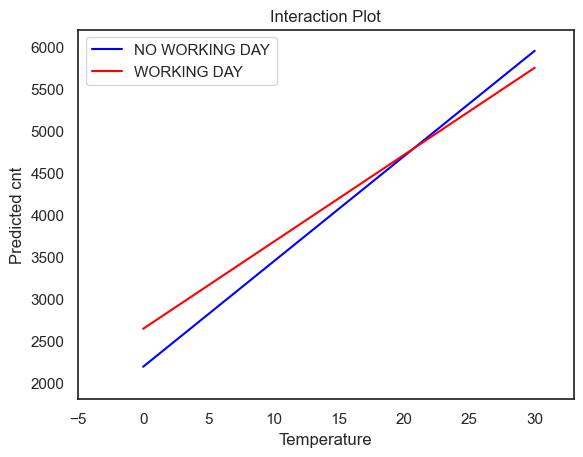

In [84]:
# 傾きと切片の計算
temp_slope_no_workingday = lm_summary_print.loc["temp", "Weight"]
temp_slope_workingday = (
    lm_summary_print.loc["temp", "Weight"]
    + lm_summary_print.loc["temp:workingday[T.WORKING DAY]", "Weight"]
)

intercept_no_workingday = lm_summary_print.loc["Intercept", "Weight"]
intercept_workingday = (
    lm_summary_print.loc["Intercept", "Weight"]
    + lm_summary_print.loc["workingday[T.WORKING DAY]", "Weight"]
)

# 交互作用プロット (interactionsパッケージ不使用)
fig, ax = plt.subplots()

# NO WORKING DAY のデータ
# x_no_working = dat[dat["workingday"] == "NO WORKING DAY"]["temp"]
# y_no_working = mod.predict(dat[dat["workingday"] == "NO WORKING DAY"])

ax.plot(
    [0, 30],  # 温度の範囲 (適宜調整)
    [intercept_no_workingday, intercept_no_workingday + temp_slope_no_workingday * 30],
    color="blue",
    label="NO WORKING DAY",
)

# WORKING DAY のデータ
# x_working = dat[dat["workingday"] == "WORKING DAY"]["temp"]
# y_working = mod.predict(dat[dat["workingday"] == "WORKING DAY"])
ax.plot(
    [0, 30],  # 温度の範囲 (適宜調整)
    [intercept_workingday, intercept_workingday + temp_slope_workingday * 30],
    color="red",
    label="WORKING DAY",
)

ax.set_xlim(-5, 33)
ax.set_ylim(1800, 6200)
ax.set_xlabel("Temperature")
ax.set_ylabel("Predicted cnt")
ax.set_title("Interaction Plot")
ax.legend()
plt.show()

In [88]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from patsy import dmatrix
import statsmodels.api as sm

# bike データが定義されていると仮定します。
# サンプルデータを作成 (実際のデータに合わせて変更してください)
np.random.seed(0)
n_samples = 731  # bikeデータのサンプル数に合わせる
# df_bike = pd.DataFrame(
#     {
#         "temp": np.random.rand(n_samples) * 40,  # 温度の範囲を調整
#         "cnt": np.random.randint(0, 8000, n_samples),  # レンタルバイク数の範囲を調整
#     }
# )

# 1. 線形モデル
mod_simple = ols("cnt ~ temp", data=df_bike_processed).fit()
df_bike_processed["pred.lm"] = mod_simple.predict(df_bike_processed)

# 2. 対数変換
df_bike_processed["log.temp"] = np.log(df_bike_processed["temp"] + 10)
# mod_log = ols("cnt ~ log.temp", data=df_bike_processed).fit()
mod_log = ols("cnt ~ np.log(temp + 10)", data=df_bike_processed).fit()
df_bike_processed["pred.sqrt"] = mod_log.predict(
    df_bike_processed
)  # pred.sqrt はRコードの名残

# 3. カテゴリ化

df_bike_processed["cat_temp"] = pd.cut(  # 列名を cat_temp に変更
    df_bike_processed["temp"],
    bins=np.linspace(
        df_bike_processed["temp"].min(), df_bike_processed["temp"].max(), 10
    ),
    include_lowest=True,
    labels=False,
)
mod_cat = ols("cnt ~ C(cat_temp)", data=df_bike_processed).fit()  # フォーミュラも変更
df_bike_processed["pred.cat"] = mod_cat.predict(df_bike_processed)

# 4. GAM (statsmodelsを使って近似)
transformed_x = dmatrix(
    "cr(temp, df=4)", {"temp": df_bike_processed["temp"]}, return_type="dataframe"
)  # 自由度4の自然スプライン基底でtempを変換
mod_gam = sm.GLM(df_bike_processed["cnt"], transformed_x).fit()
df_bike_processed["pred.gam"] = mod_gam.predict(transformed_x)


# プロット (fig, axを使用)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

model_types = {
    "pred.lm": "Linear model",
    "pred.sqrt": "Linear model with log(temp + 10)",
    "pred.cat": "Linear model with categorized temp",
    "pred.gam": "GAM",
}

for i, (col, title) in enumerate(model_types.items()):
    ax = axes[i]
    ax.scatter(
        df_bike_processed["temp"], df_bike_processed["cnt"], s=10, alpha=0.3
    )  # 散布図を小さく、透明にする
    ax.plot(
        df_bike_processed["temp"], df_bike_processed[col], color="blue", linewidth=2
    )
    ax.set_title(title)
    ax.set_xlabel("Temperature (temp)")
    if i == 0 or i == 2:  # 左側のプロットのみy軸ラベルを表示
        ax.set_ylabel("(Predicted) Number of rented bikes")


plt.tight_layout()
plt.show()

PatsyError: Error evaluating factor: NameError: name 'cat' is not defined
    cnt ~ C(cat.temp)
          ^^^^^^^^^^^